# AWS API Label Propagation

In [1]:
# Import required modules
import json
import config
from data_manager import DataManager
from label_propagation import LabelPropagator
from evaluator import Evaluator
from animation import create_animation
from IPython.display import display
from visualization import (
    print_evaluation_summary,
    print_service_predictions_summary,
    create_results_dashboard,
    save_visualization_summary
)

## Step 1: Initialize and Load Data

In [2]:
# Initialize data manager
data_manager = DataManager()

# Load embeddings for labeled services (using with_service_params for within-service)
data_manager.load_method_embeddings(config.LABELED_SERVICES, 'with_params')

# Try to load existing indexes or build new ones
if config.ANNOY_INDEXES_DIR.exists() and any(config.ANNOY_INDEXES_DIR.iterdir()):
    print(f"\n📂 Loading existing Annoy indexes from {config.ANNOY_INDEXES_DIR}")
    data_manager.load_indexes()
else:
    print(f"\n📁 Creating new Annoy indexes directory: {config.ANNOY_INDEXES_DIR}")
    config.ANNOY_INDEXES_DIR.mkdir(exist_ok=True, parents=True)
    # Save Annoy indexes
    print("\n💾 Saving Annoy indexes...")
    data_manager.save_indexes()

🏷️ Loaded 85 manual labels
📂 Loading embeddings for services: ['S3', 'DynamoDB', 'Lambda', 'EC2', 'IAM', 'SSM', 'SQS', 'SNS']
📊 Using embedding format: with_params
📁 S3: 113 methods
📁 DynamoDB: 61 methods
📁 Lambda: 72 methods
📁 EC2: 661 methods
📁 IAM: 168 methods
📁 SSM: 148 methods
📁 SQS: 27 methods
📁 SNS: 46 methods
✅ Loaded 1296 method embeddings
🏷️ Found 85 labeled methods

📂 Loading existing Annoy indexes from ../../embeddings/annoy_indexes
📂 Loaded Annoy index for s3: 113 methods
📂 Loaded Annoy index for dynamodb: 61 methods
📂 Loaded Annoy index for lambda: 72 methods
📂 Loaded Annoy index for ec2: 661 methods
📂 Loaded Annoy index for iam: 168 methods
📂 Loaded Annoy index for ssm: 148 methods
📂 Loaded Annoy index for sqs: 27 methods
📂 Loaded Annoy index for sns: 46 methods


## Step 2: Data Analysis

In [3]:
# Initialize evaluator
evaluator = Evaluator(data_manager)

# Analyze data distribution and coverage
evaluator.analyze_label_distribution()
evaluator.analyze_method_coverage()

📊 Label Distribution by Service:
--------------------------------------------------
S3:
  none: 2 (20.0%)
  sink: 4 (40.0%)
  source: 4 (40.0%)

DYNAMODB:
  source: 5 (45.5%)
  sink: 3 (27.3%)
  none: 3 (27.3%)

LAMBDA:
  source: 4 (33.3%)
  sink: 6 (50.0%)
  none: 2 (16.7%)

EC2:
  sink: 7 (70.0%)
  none: 2 (20.0%)
  source: 1 (10.0%)

IAM:
  source: 2 (18.2%)
  sink: 8 (72.7%)
  none: 1 (9.1%)

SSM:
  source: 7 (70.0%)
  sink: 2 (20.0%)
  none: 1 (10.0%)

SQS:
  none: 4 (40.0%)
  source: 3 (30.0%)
  sink: 3 (30.0%)

SNS:
  none: 3 (27.3%)
  sink: 5 (45.5%)
  source: 3 (27.3%)

📈 Method Coverage Analysis:
--------------------------------------------------
S3:
📊 10/113 labeled (8.8% coverage)
🔍 103 methods need propagation
DYNAMODB:
📊 11/61 labeled (18.0% coverage)
🔍 50 methods need propagation
LAMBDA:
📊 12/72 labeled (16.7% coverage)
🔍 60 methods need propagation
EC2:
📊 10/661 labeled (1.5% coverage)
🔍 651 methods need propagation
IAM:
📊 11/168 labeled (6.5% coverage)
🔍 157 methods ne

## Step 3: Model Evaluation and Parameter Tuning

📊 Data summary:
   • Total samples: 85
   • Embedding dimension: 1024
   • Unique labels: {'sink', 'source', 'none'}
   • Label distribution: {'none': 18, 'sink': 38, 'source': 29}
🔍 Finding optimal k value:
   • Min class size: 18
   • Max CV folds: 5
   k=5: F1-score = 0.652 ± 0.075
   k=7: F1-score = 0.612 ± 0.065
   k=9: F1-score = 0.669 ± 0.135
   k=11: F1-score = 0.723 ± 0.147
   k=13: F1-score = 0.749 ± 0.164
   k=15: F1-score = 0.729 ± 0.133
   k=17: F1-score = 0.674 ± 0.170
✅ Best k value: 13 (F1-score: 0.749)
🔍 DEBUG - Conflicting Methods:
--------------------------------------------------
Found 6 conflicting predictions:
  • ssm.create_association
    Actual: sink
    Predicted: source
  • sqs.set_queue_attributes
    Actual: sink
    Predicted: none
  • ssm.delete_parameter
    Actual: none
    Predicted: source
  • ssm.start_session
    Actual: sink
    Predicted: source
  • lambda.delete_function
    Actual: none
    Predicted: sink
  • iam.create_user
    Actual: sink
  

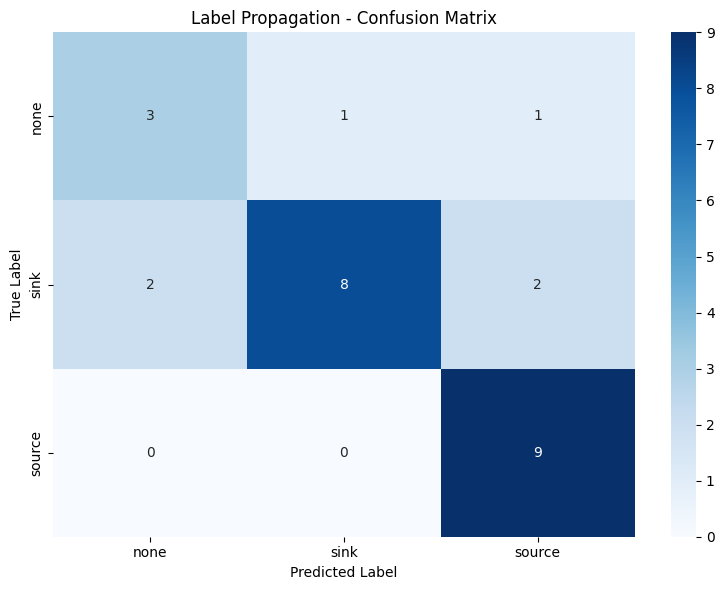

In [4]:
# Find optimal k value
best_k = evaluator.find_optimal_k()

# Evaluate propagation performance
evaluation_results = evaluator.evaluate_propagation(k=best_k)

## Step 4: Adaptive Within-Service Label Propagation

In [5]:
# Initialize propagator
propagator = LabelPropagator(data_manager)

# Run adaptive within-service propagation
# The algorithm automatically reduces threshold from DEFAULT_SERVICE_THRESHOLD down to DEFAULT_MIN_THRESHOLD
print(f"🚀 Starting adaptive propagation with threshold: {config.DEFAULT_SERVICE_THRESHOLD}")
print(f"📉 Will automatically reduce to minimum: {config.DEFAULT_MIN_THRESHOLD}")

final_predictions = propagator.propagate_all_services(
    k=best_k,
    threshold=config.DEFAULT_SERVICE_THRESHOLD,
    max_iterations=config.DEFAULT_MAX_ITERATIONS,
    min_confidence=config.DEFAULT_MIN_CONFIDENCE,
    min_threshold=config.DEFAULT_MIN_THRESHOLD,
    save_history=True
)

print(f"\n✅ Adaptive propagation complete!")
print(f"📊 Total within-service predictions: {sum(len(pred) for pred in final_predictions.values())}")

# Show summary of predictions by service
print_service_predictions_summary(final_predictions)

🚀 Starting adaptive propagation with threshold: 0.9
📉 Will automatically reduce to minimum: 0.5

🔄 Propagating in s3: 10 labeled → 103 unlabeled
🔄 Iteration 1: 103 remaining unlabeled (threshold: 0.9)
✅ Added 5 new predictions
🔄 Iteration 2: 98 remaining unlabeled (threshold: 0.9)
⚠️ No new predictions in iteration 2
📉 Lowering threshold to 0.8
🔄 Iteration 3: 98 remaining unlabeled (threshold: 0.8)
✅ Added 44 new predictions
🔄 Iteration 4: 54 remaining unlabeled (threshold: 0.8)
✅ Added 35 new predictions
🔄 Iteration 5: 19 remaining unlabeled (threshold: 0.8)
✅ Added 5 new predictions
🔄 Iteration 6: 14 remaining unlabeled (threshold: 0.8)
✅ Added 1 new predictions
🔄 Iteration 7: 13 remaining unlabeled (threshold: 0.8)
⚠️ No new predictions in iteration 7
📉 Lowering threshold to 0.7
🔄 Iteration 8: 13 remaining unlabeled (threshold: 0.7)
✅ Added 8 new predictions
🔄 Iteration 9: 5 remaining unlabeled (threshold: 0.7)
✅ Added 1 new predictions
🔄 Iteration 10: 4 remaining unlabeled (thresho

## Step 5: Cross-Service Propagation

In [6]:
print("\n" + "="*50)
print("Cross-Service Propagation Testing")
print("="*50)

cross_service_predictions = {}

for source_service, target_service in config.CROSS_SERVICE_TEST_PAIRS:
    if (source_service in data_manager.service_methods and 
        target_service in data_manager.service_methods):
        
        print(f"\n🔀 Testing: {source_service} → {target_service}")
        cross_pred = propagator.propagate_cross_service(
            source_service, target_service, 
            k=best_k, 
            threshold=config.DEFAULT_SERVICE_THRESHOLD
        )
        
        if cross_pred:
            cross_service_predictions[f"{source_service}_to_{target_service}"] = cross_pred
            print_service_predictions_summary({f"{source_service}_to_{target_service}": cross_pred})
        else:
            print(f"❌ No predictions made (low similarity or no data)")


Cross-Service Propagation Testing


## Step 6: Results Visualization

Create visualizations to analyze the quality and distribution of predictions.

🎨 CREATING VISUALIZATION DASHBOARD


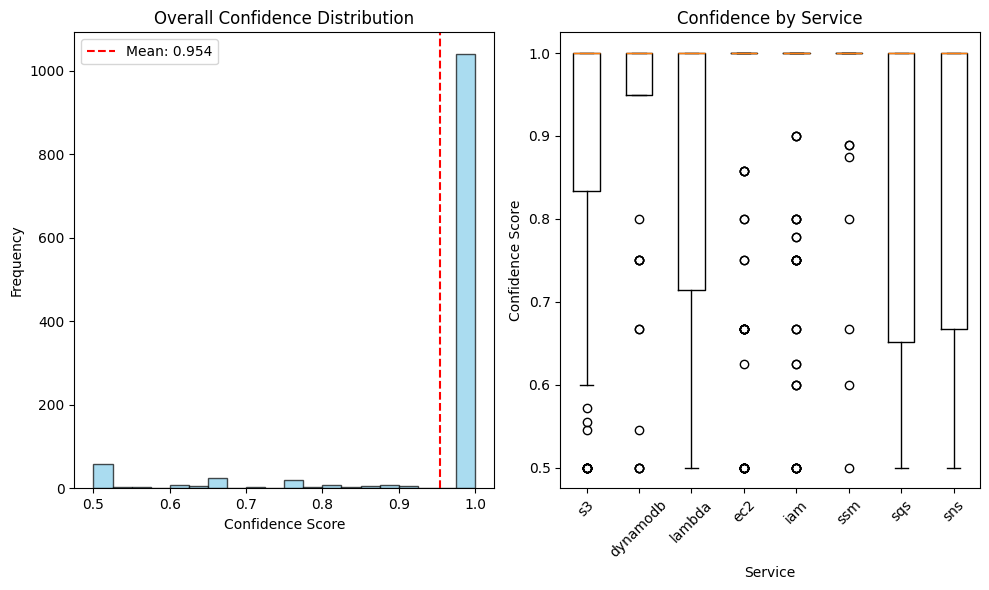

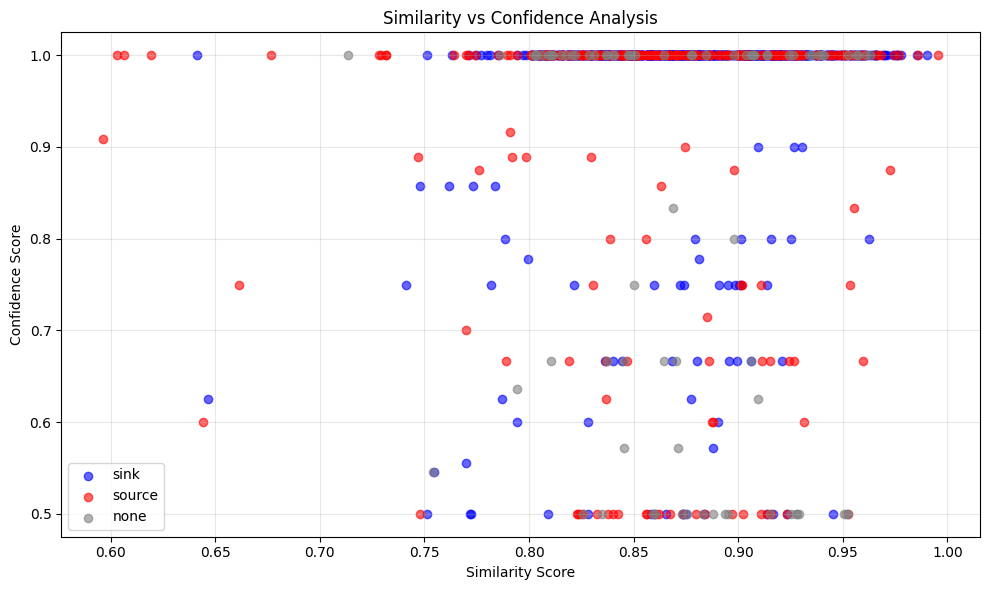

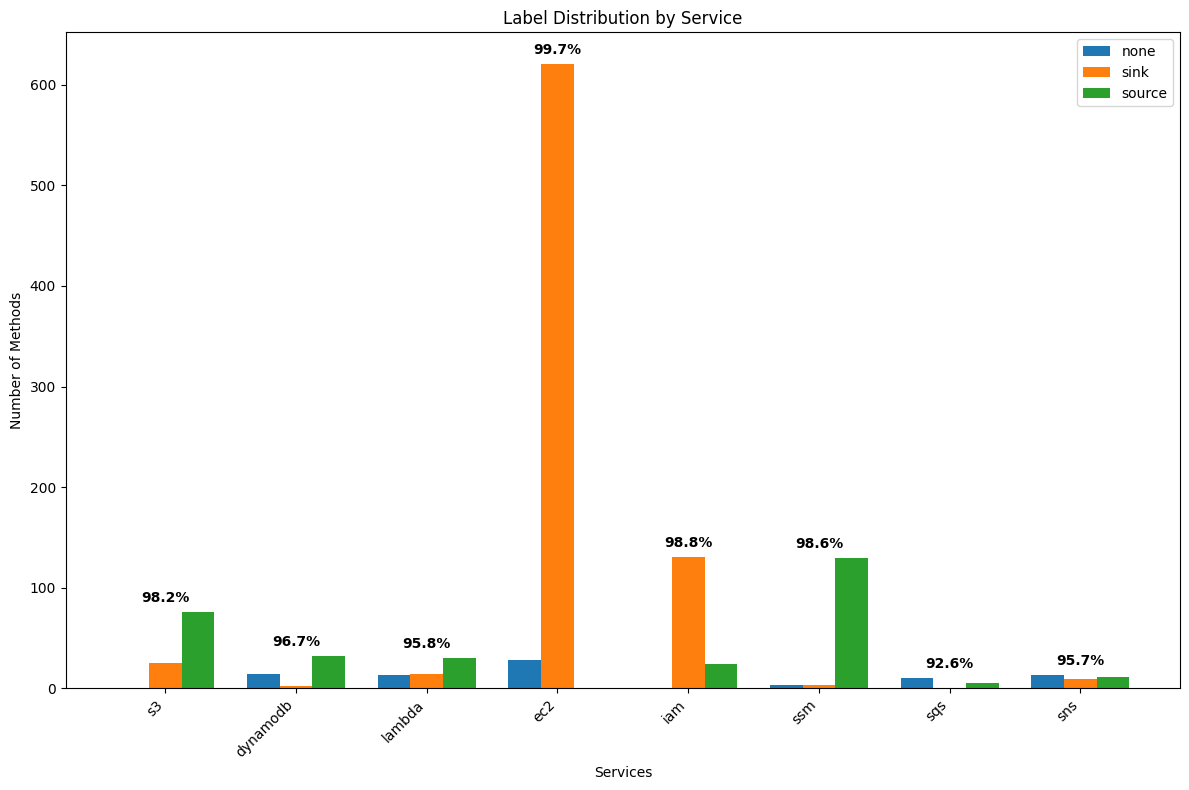

✅ Dashboard visualization complete!


In [ ]:
# Create comprehensive visualization dashboard
total_methods = {service: len(methods_list) for service, methods_list in data_manager.service_methods.items()}
create_results_dashboard(final_predictions, total_methods, data_manager.method_labels)

In [ ]:
anim = create_animation(
    data_manager, 
    config.SERVICE_TO_ANIMATE, 
    save_gif=True
)

display(anim)

## Step 7: Save Results

In [8]:
# Save within-service predictions
within_service_metadata = {
    'type': 'within_service_propagation',
    'embedding_format': 'with_service_params',
    'k_neighbors': best_k,
    'initial_threshold': config.DEFAULT_SERVICE_THRESHOLD,
    'minimum_threshold': config.DEFAULT_MIN_THRESHOLD,
    'adaptive_threshold': True,
    'labeled_services': config.LABELED_SERVICES,
    'total_labeled_methods': len(data_manager.method_labels),
    'total_predictions': sum(len(pred) for pred in final_predictions.values())
}

data_manager.save_predictions(
    final_predictions, 
    config.WITHIN_SERVICE_PREDICTIONS_FILE, 
    within_service_metadata
)

# Save cross-service predictions if any
if cross_service_predictions:
    cross_service_metadata = {
        'type': 'cross_service_propagation',
        'embedding_format': 'method_only',
        'k_neighbors': best_k,
        'similarity_threshold': config.DEFAULT_SERVICE_THRESHOLD,
        'total_predictions': sum(len(pred) for pred in cross_service_predictions.values())
    }
    
    data_manager.save_predictions(
        cross_service_predictions, 
        config.CROSS_SERVICE_PREDICTIONS_FILE, 
        cross_service_metadata
    )

# Save visualization summary
save_visualization_summary(
    final_predictions, 
    config.VISUALIZATION_SUMMARY_FILE, 
    within_service_metadata
)

# Generate and save comprehensive summary
summary = evaluator.generate_summary(
    final_predictions, 
    cross_service_predictions,
    evaluation_results, 
    best_k
)

with open(config.PROPAGATION_SUMMARY_FILE, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"\n💾 Summary saved to: {config.PROPAGATION_SUMMARY_FILE}")

💾 Predictions saved to: within_service_predictions.json
📊 Visualization summary saved to: visualization_summary.json

💾 Summary saved to: propagation_summary.json


## Step 8: Final Summary

In [9]:
# Print final evaluation summary
print_evaluation_summary(
    evaluation_results, 
    best_k, 
    len(data_manager.method_labels), 
    sum(len(pred) for pred in final_predictions.values())
)

# Print recommendations and next steps
evaluator.print_final_summary(summary, final_predictions, cross_service_predictions)

print("\n🎊 Process complete! Review the generated files and high-confidence predictions.")

🎯 EVALUATION SUMMARY
📊 Total labeled methods: 85
🔍 Optimal k value: 13
📈 Total predictions made: 1194
📊 Overall accuracy: 0.769
📊 Macro F1-score: 0.740
📊 Weighted F1-score: 0.764

📋 Per-class performance:
    none: P=0.600, R=0.600, F1=0.600, Support=5.0
    sink: P=0.889, R=0.667, F1=0.762, Support=12.0
  source: P=0.750, R=1.000, F1=0.857, Support=9.0

FINAL RESULTS AND RECOMMENDATIONS
🎉 Label propagation complete!
📊 Within-service predictions: 1194
🎯 Next Steps Recommendations:
1. ✅ High-confidence services (ready for use):
   • s3: 101 predictions, 0.890 avg confidence
   • dynamodb: 48 predictions, 0.910 avg confidence
   • lambda: 57 predictions, 0.869 avg confidence
   • ec2: 649 predictions, 0.981 avg confidence
   • iam: 155 predictions, 0.934 avg confidence
   • ssm: 136 predictions, 0.987 avg confidence
   • sqs: 15 predictions, 0.840 avg confidence
   • sns: 33 predictions, 0.837 avg confidence
2. ⚠️  Services needing manual review:
   • sqs: 15 predictions (review low-conf